# Spatial Data Final Project - Multiple Lags (t-1,t-2,t-3,t-4)

This notebook contains our model training and prediction using all four lags. The process is exactly the same as in the one_lag_prediction_work.ipynb. But, the main difference is how we selected the lags. 
The reason this training process is separated is also to run it on another google colab instance.

In [2]:
import pandas as pd
import numpy as np 
import sklearn
from scipy.stats import norm
import time
import os
import matplotlib.pyplot as plt

import xgboost
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

#utils
from functools import partial

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set current dictionary
current_dir = '/content/drive/MyDrive/final_project/'

In [6]:
# Set output dictionary
output_dir = '/content/drive/MyDrive/final_project/'

In [7]:
# Loading final data
df = pd.read_csv(curret_dir +'data/processed/master_data.csv').iloc[:,0:-1]
df.rename(columns = {'newcases_tplus1' : 'newcases_tplus2', 'newcases_tplus2' : 'newcases_tplus3', 'newcases_tplus4' : 'newcases_tplus5', 'newcases' : 'newcases_tplus1'},inplace=True)

In [8]:
df.head()

,province,Y-W,newcases_tplus1,newcases_tminus1,newcases_tminus2,newcases_tminus3,newcases_tminus4,newcases_tplus2,newcases_tplus3,newcases_tplus5,...,workplaces_tminus4,residential_tminus1,residential_tminus2,residential_tminus3,residential_tminus4,2019employment_rate,2019intermunicipal_migration_rate,2019annual_contrib_margin,2019share_age_64,2019number_workplaces
0,South Karelia,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,67.4,-488,387.3,27.4,47995
1,Southern Ostrobothnia,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,73.8,-935,123.6,25.4,77419
2,Southern Savonia,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,68.9,-1228,143.5,30.9,50145
3,Kainuu,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,68.3,-462,857.2,28.5,27218
4,Tavastia Proper,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,73.1,-69,197.5,25.3,64199


In [9]:
provinces = list(df['province'].unique())

In [10]:
provinces

['South Karelia',
 'Southern Ostrobothnia',
 'Southern Savonia',
 'Kainuu',
 'Tavastia Proper',
 'Central Ostrobothnia',
 'Central Finland',
 'Kymenlaakso',
 'Lapland',
 'Pirkanmaa',
 'Ostrobothnia',
 'North Karelia',
 'Northern Ostrobothnia',
 'Northern Savonia',
 'Päijänne Tavastia',
 'Satakunta',
 'Uusimaa',
 'Southwest Finland']

In [11]:
df.columns

Index(['province', 'Y-W', 'newcases_tplus1', 'newcases_tminus1',
       'newcases_tminus2', 'newcases_tminus3', 'newcases_tminus4',
       'newcases_tplus2', 'newcases_tplus3', 'newcases_tplus5', 'spc_tminus1',
       'spc_tminus2', 'spc_tminus3', 'spc_tminus4', 'temp_min_tminus1',
       'temp_min_tminus2', 'temp_min_tminus3', 'temp_min_tminus4',
       'temp_max_tminus1', 'temp_max_tminus2', 'temp_max_tminus3',
       'temp_max_tminus4', 'retail_tminus1', 'retail_tminus2',
       'retail_tminus3', 'retail_tminus4', 'grocery_tminus1',
       'grocery_tminus2', 'grocery_tminus3', 'grocery_tminus4',
       'parks_tminus1', 'parks_tminus2', 'parks_tminus3', 'parks_tminus4',
       'transit_tminus1', 'transit_tminus2', 'transit_tminus3',
       'transit_tminus4', 'workplaces_tminus1', 'workplaces_tminus2',
       'workplaces_tminus3', 'workplaces_tminus4', 'residential_tminus1',
       'residential_tminus2', 'residential_tminus3', 'residential_tminus4',
       '2019employment_rate', '2019

In [13]:
def choosehorizon(dataframe,pred : int,lags):
    """
    This function takes in the master dataframe and spits out the lags that you want to include,
    and then sorts the data so that it's easier to look at.
    """
    if pred not in [1,2,4]:
        print(f"Sorry, but the only available prediction horizons are 1,2 and 4 weeks ahead!")
        return None
    elif (max(lags) > 4) or (min(lags) < 1):
        if len(lags) == 0:
            print("You have specified zero lags! Nonsense!")
        else: print("Your lags are out of bounds...")
    
    lagcols = [col for col in list(dataframe.columns) if 'tminus' in col]
    
    lagschosen = []
    for lag in lags:
        lagschosen += [col for col in lagcols if str(lag) in col]
        
    lagschosen.sort()
    sociocols = [col for col in list(dataframe.columns) if '2019' in col]
    indices = ['Y-W','province']
    y = f"newcases_tplus{pred}"
    
    allcols = indices + [y] + lagschosen + sociocols
    
    # Given lags, take out data that contains NaNs due to data unavailability
    # First week when we have data is 2020-10, so add up weeks according to lags..
    max_lag = max(lags)
    # first_week = f"2020-{10+max_lag}"
    first_week = '2021-01'
    last_week = '2021-52'
    
    # Given that we are predicting into the future, we need to take off as many weeks as we
    # are predicting into the future for, because otherwise we have NaNs..
    last_week = f"2022-{10-pred}"
    
    # We also need to take care of the fact that we only have Google Mobility data up to 2021-52
    last_week_google = f"2021-52"
    
    last_effective_week = [last_week,last_week_google]
    last_effective_week.sort()
    dataframe = dataframe[(dataframe['Y-W'] >= first_week) & (dataframe['Y-W'] <= last_effective_week[0])]
    dataframe.reset_index(drop=True,inplace=True)
    return dataframe[allcols],y

Select all t-1,t-2,t-3,t-4 lags for this model training

In [14]:
data,depvarname = choosehorizon(df,1,[1,2,3,4]) #compared to the one lag notebook, here we selected all lags

In [15]:
google_data_list = [
"retail",
"grocery",
"parks",
"transit",
"workplaces",
"residential"
]

google_datas = []
for google_data in google_data_list:
  google_datas += [col for col in data.columns if google_data in col]

In [16]:
google_datas

['retail_tminus1',
 'retail_tminus2',
 'retail_tminus3',
 'retail_tminus4',
 'grocery_tminus1',
 'grocery_tminus2',
 'grocery_tminus3',
 'grocery_tminus4',
 'parks_tminus1',
 'parks_tminus2',
 'parks_tminus3',
 'parks_tminus4',
 'transit_tminus1',
 'transit_tminus2',
 'transit_tminus3',
 'transit_tminus4',
 'workplaces_tminus1',
 'workplaces_tminus2',
 'workplaces_tminus3',
 'workplaces_tminus4',
 '2019number_workplaces',
 'residential_tminus1',
 'residential_tminus2',
 'residential_tminus3',
 'residential_tminus4']

In [18]:
data.head()

,Y-W,province,newcases_tplus1,newcases_tminus1,newcases_tminus2,newcases_tminus3,newcases_tminus4,spc_tminus1,spc_tminus2,spc_tminus3,...,temp_max_tminus3,temp_max_tminus4,temp_min_tminus1,temp_min_tminus2,temp_min_tminus3,temp_min_tminus4,2019employment_rate,2019intermunicipal_migration_rate,2019annual_contrib_margin,2019share_age_64
0,2021-01,South Karelia,0.743388,0.915088,0.581037,1.236188,0.488772,1.059205,0.813258,1.179916,...,1.414286,-2.014286,-3.385714,-2.557143,-1.614286,-5.328571,67.4,-488,387.3,27.4
1,2021-01,Southern Ostrobothnia,0.000000,0.000000,0.231281,0.231281,0.919979,0.987278,0.742646,1.177277,...,2.600000,-1.385714,-4.342857,-2.928571,-0.985714,-4.100000,73.8,-935,123.6,25.4
2,2021-01,Southern Savonia,0.000000,0.319750,0.471786,1.408454,1.479570,1.043021,0.784992,1.085412,...,0.771429,-1.171429,-7.200000,-4.471429,-4.314286,-4.442857,68.9,-1228,143.5,30.9
3,2021-01,Kainuu,0.983755,0.000000,0.000000,0.000000,0.000000,1.015423,0.718770,0.996697,...,1.714286,-1.885714,-1.642857,-1.842857,-0.685714,-5.242857,68.3,-462,857.2,28.5
4,2021-01,Tavastia Proper,1.323183,0.902441,0.948898,1.224836,1.398341,1.110361,0.976796,1.292484,...,-3.042857,-2.357143,-10.142857,-8.771429,-8.714286,-6.157143,73.1,-69,197.5,25.3


In [19]:
data.shape[0]/18

52.0

## Training setup

In [20]:
training_size = 30 # week
testing_size = 1 # week
num_counties = len(data.province.value_counts().index)
time_steps = 22

## Model tracking

In [17]:
train_r2_xgb = dict()
train_rmse_xgb = dict()
train_mae_xgb = dict()
test_rmse_xgb = dict()
test_mae_xgb = dict()
tuned_params_xgb = dict()

## Model grid setup

In [ ]:
# Setting Hyperparameters. Please refer to the SI for more information
xgb_params = dict(  learning_rate=np.arange(0.05,0.3,0.05),
                     #  n_estimators=np.arange(150,400,100), 
                     #gamma = np.arange(0,,1),
                     max_depth=[int(i) for i in np.arange(3,10,1)])  #test on 3-10

In [ ]:
xgb_params

{'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25]),
 'max_depth': [3, 4, 5, 6, 7, 8, 9]}

## Model training

In [ ]:
for i in range(time_steps):
    
    training_df = data.iloc[:(i+training_size)*num_counties,:]
    testing_df = data.iloc[(i+training_size)*num_counties:(i+training_size+testing_size)*num_counties,:]
    
#     start_time = time.time()

    # in the 2-week prediction model, the target variable is LOG_DELTA_INC_RATE_T_14
    X_train = training_df.iloc[:,3:]
    y_train = training_df[depvarname]
    X_test = testing_df.iloc[:,3:]
    y_test = testing_df[depvarname]
    
    print(X_train.shape)
    print(y_train.shape)
    
    print(X_test.shape)
    print(y_test.shape)
    
    #scaling X
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    
    #inititalization
    xgb_model = xgboost.XGBRegressor(seed=42, verbosity=0, tree_method='gpu_hist', nthreads=-1)
    
    #cross validation
    xgb_cv = GridSearchCV(xgb_model, xgb_params, 
                                    scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3)
    
    xgb_optimized = xgb_cv.fit(X_train, y_train)
    best_xgb = xgb_optimized.best_estimator_
    tuned_params_xgb['whole', i] = xgb_optimized.best_params_

    # save the model to disk
    filename = 'pickle_models.pkl'
    with open(filename, 'wb') as file:
      pickle.dump(xgb_optimized, file)
    
    # model evaluation for training set
    r2_train_xgb = round(best_xgb.score(X_train, y_train),2)
    train_r2_xgb['whole', i] = r2_train_xgb
    
    y_train_predicted_xgb = best_xgb.predict(X_train)
    rmse_train_xgb = (np.sqrt(mean_squared_error(y_train, y_train_predicted_xgb)))
    train_rmse_xgb['whole', i] = rmse_train_xgb
    train_mae_xgb['whole', i] =  mean_absolute_error(y_train, y_train_predicted_xgb)


    # model evaluation for test set
    y_test_predicted_xgb = best_xgb.predict(X_test)
    rmse_test_xgb = (np.sqrt(mean_squared_error(y_test, y_test_predicted_xgb)))
    test_rmse_xgb['whole', i] = rmse_test_xgb
    test_mae_xgb['whole', i] = mean_absolute_error(y_test, y_test_predicted_xgb)
        
    print(f"Finished {i}th round...")


(540, 20)
(540,)
(18, 20)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 0th round...
(558, 20)
(558,)
(18, 20)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 1th round...
(576, 20)
(576,)
(18, 20)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 2th round...
(594, 20)
(594,)
(18, 20)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 3th round...
(612, 20)
(612,)
(18, 20)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 4th round...
(630, 20)
(630,)
(18, 20)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 5th round...
(648, 20)
(648,)
(18, 20)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 6th round...
(666, 20)
(666,)
(18, 20)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 7th round...
(684, 20)
(684,)
(18, 20)
(18,)
Fitting 5 folds for each of 35 candidate

In [ ]:
tuned_params_xgb

{('whole', 0): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 1): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 2): {'learning_rate': 0.25, 'max_depth': 3},
 ('whole', 3): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 4): {'learning_rate': 0.05, 'max_depth': 4},
 ('whole', 5): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 6): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 7): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 8): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 9): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 10): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 11): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 12): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 13): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 14): {'learning_rate': 0.05, 'max_depth': 4},
 ('whole', 15): {'learning_rate': 0.05, 'max_depth': 4},
 ('whole', 16): {'learning_rate': 0.05, 'max_depth': 4},
 ('whole', 17): {'learning_rate': 0.05, '

In [ ]:
print(np.exp(y_test_predicted_xgb - 1))
print(np.exp(y_test - 1))

[ 6.709479   7.0252852  3.99692    1.5464776  9.281276   4.177516
 10.429659   9.796121   9.108885  12.83561    9.279632   4.4728775
 17.044573   7.1848707 11.087065  12.638855  14.1307    10.5576515]
918    12.222710
919    14.056862
920     9.238991
921     7.811299
922    24.263857
923     9.782927
924    16.061831
925    20.658505
926    16.464492
927    23.108279
928    27.025203
929    14.562339
930    15.480246
931    13.155826
932    19.640471
933    20.007152
934    55.771969
935    17.378568
Name: newcases_tplus1, dtype: float64


In [ ]:
train_r2_xgb 




{('whole', 0): 0.84,
 ('whole', 1): 0.85,
 ('whole', 2): 0.97,
 ('whole', 3): 0.86,
 ('whole', 4): 0.9,
 ('whole', 5): 0.86,
 ('whole', 6): 0.85,
 ('whole', 7): 0.85,
 ('whole', 8): 0.85,
 ('whole', 9): 0.85,
 ('whole', 10): 0.85,
 ('whole', 11): 0.85,
 ('whole', 12): 0.85,
 ('whole', 13): 0.85,
 ('whole', 14): 0.89,
 ('whole', 15): 0.9,
 ('whole', 16): 0.9,
 ('whole', 17): 0.94,
 ('whole', 18): 0.87,
 ('whole', 19): 0.87,
 ('whole', 20): 0.91,
 ('whole', 21): 0.93}

In [ ]:
train_rmse_xgb 


{('whole', 0): 0.27608696757970974,
 ('whole', 1): 0.27585945103849074,
 ('whole', 2): 0.12964804043142977,
 ('whole', 3): 0.27255636544984263,
 ('whole', 4): 0.22218191256753977,
 ('whole', 5): 0.2746511904580734,
 ('whole', 6): 0.2764654468654781,
 ('whole', 7): 0.278283952321141,
 ('whole', 8): 0.28098713988461216,
 ('whole', 9): 0.27881270426977506,
 ('whole', 10): 0.2832856500838626,
 ('whole', 11): 0.2815213057008538,
 ('whole', 12): 0.28427767507786916,
 ('whole', 13): 0.282878598808779,
 ('whole', 14): 0.23956204897169972,
 ('whole', 15): 0.2365647712749976,
 ('whole', 16): 0.23699308345318998,
 ('whole', 17): 0.18836523052343673,
 ('whole', 18): 0.2850922212989338,
 ('whole', 19): 0.28534798224361596,
 ('whole', 20): 0.24028009057139033,
 ('whole', 21): 0.2205969335446428}

In [ ]:

test_rmse_xgb 

{('whole', 0): 0.29108099877139076,
 ('whole', 1): 0.23377469114127436,
 ('whole', 2): 0.36663217326406466,
 ('whole', 3): 0.39030319213376913,
 ('whole', 4): 0.3344611677358675,
 ('whole', 5): 0.3230573427515609,
 ('whole', 6): 0.35948532385641235,
 ('whole', 7): 0.29660729056598484,
 ('whole', 8): 0.4589669150094408,
 ('whole', 9): 0.4146937041156961,
 ('whole', 10): 0.2798602212904445,
 ('whole', 11): 0.3652068924221919,
 ('whole', 12): 0.3571729545311401,
 ('whole', 13): 0.37115865426320077,
 ('whole', 14): 0.29007069043523004,
 ('whole', 15): 0.4224306336361068,
 ('whole', 16): 0.33693536028745247,
 ('whole', 17): 0.432288816694758,
 ('whole', 18): 0.29561843266283916,
 ('whole', 19): 0.41808401642632653,
 ('whole', 20): 0.4526082345251126,
 ('whole', 21): 0.8444338905784806}

In [14]:
test_rmse = { 0: 0.29108099877139076,
  1: 0.23377469114127436,
  2: 0.36663217326406466,
  3: 0.39030319213376913,
  4: 0.3344611677358675,
  5: 0.3230573427515609,
  6: 0.35948532385641235,
  7: 0.29660729056598484,
  8: 0.4589669150094408,
  9: 0.4146937041156961,
  10: 0.2798602212904445,
  11: 0.3652068924221919,
  12: 0.3571729545311401,
  13: 0.37115865426320077,
  14: 0.29007069043523004,
  15: 0.4224306336361068,
  16: 0.33693536028745247,
  17: 0.432288816694758,
  18: 0.29561843266283916,
  19: 0.41808401642632653,
  20: 0.4526082345251126,
  21: 0.8444338905784806}

In [15]:
sum_rmse=0
for key in test_rmse.keys():
  sum_rmse += test_rmse[key]

In [16]:
avg_test_rmse = sum/22
print("average_test_rmse: ", avg_test_rmse)

average_test_rmse:  0.37886052714085194


In [ ]:
test_mae_xgb

{('whole', 0): 0.22749556042845212,
 ('whole', 1): 0.1845483732782182,
 ('whole', 2): 0.27287300564081296,
 ('whole', 3): 0.29807372722372044,
 ('whole', 4): 0.25948279574199773,
 ('whole', 5): 0.25250199648335747,
 ('whole', 6): 0.27434120619367686,
 ('whole', 7): 0.23506048543872143,
 ('whole', 8): 0.3806338614682368,
 ('whole', 9): 0.3206161183601397,
 ('whole', 10): 0.22396681549216346,
 ('whole', 11): 0.27917784127702194,
 ('whole', 12): 0.3246455633804372,
 ('whole', 13): 0.3259584678733845,
 ('whole', 14): 0.257501380171202,
 ('whole', 15): 0.3440931941019929,
 ('whole', 16): 0.277434400528138,
 ('whole', 17): 0.3311537321413874,
 ('whole', 18): 0.2565840378305621,
 ('whole', 19): 0.3496635574745295,
 ('whole', 20): 0.3544717282552493,
 ('whole', 21): 0.7651989428653828}

In [17]:
test_mae = {0: 0.22749556042845212,
1: 0.1845483732782182,
2: 0.27287300564081296,
3: 0.29807372722372044,
4: 0.25948279574199773,
5: 0.25250199648335747,
6: 0.27434120619367686,
7: 0.23506048543872143,
8: 0.3806338614682368,
9: 0.3206161183601397,
10: 0.22396681549216346,
11: 0.27917784127702194,
12: 0.3246455633804372,
13: 0.3259584678733845,
14: 0.257501380171202,
15: 0.3440931941019929,
16: 0.277434400528138,
17: 0.3311537321413874,
18: 0.2565840378305621,
19: 0.3496635574745295,
20: 0.3544717282552493,
21: 0.7651989428653828}

In [18]:
sum=0
for key in test_mae.keys():
  sum += test_mae[key]


In [19]:
avg_test_mae = sum/22
print("average_test_mae: ", avg_test_mae)

average_test_mae:  0.30888530871130837


Model 1, Model 18, Model 10

- 1: ('whole', 1): {'learning_rate': 0.05, 'max_depth': 3},
- 10: {'learning_rate': 0.05, 'max_depth': 3},
- 18: ('whole', 18): {'learning_rate': 0.05, 'max_depth': 3},

In [21]:
def get_stxgb_results(time_steps, data, learning_rate, max_depth):
  i = time_steps
  training_df = data.iloc[:(i+training_size)*num_counties,:]
  testing_df = data.iloc[(i+training_size)*num_counties:(i+training_size+testing_size)*num_counties,:]

 

  # in the 2-week prediction model, the target variable is LOG_DELTA_INC_RATE_T_14
  X_train = training_df.iloc[:,3:]
  y_train = training_df[depvarname]
  X_test = testing_df.iloc[:,3:]
  y_test = testing_df[depvarname]

  
  #scaling X
  scaler = MinMaxScaler()
  X_train_df = X_train
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  
  
  #inititalization
  xgb_model = xgboost.XGBRegressor(seed=42, verbosity=0, tree_method='gpu_hist', nthreads=-1, learning_rate=learning_rate, max_depth=max_depth)
  xgb_model.fit(X_train, y_train)

  sorted_idx = xgb_model.feature_importances_.argsort()
  plt.figure(figsize=(10,10))
  plt.barh(X_train_df.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
  plt.xlabel("Xgboost Feature Importance for model in week: {i}".format(i=i+30))

  # model evaluation for test set
  y_test_predicted_xgb = xgb_model.predict(X_test)


  predicted = np.exp(y_test_predicted_xgb )-1
  real = np.exp(y_test )-1
  return predicted, real

In [22]:
tuned_xgb_params = {0: {'learning_rate': 0.05, 'max_depth': 3},
 1: {'learning_rate': 0.05, 'max_depth': 3},
 2: {'learning_rate': 0.25, 'max_depth': 3},
 3: {'learning_rate': 0.05, 'max_depth': 3},
 4: {'learning_rate': 0.05, 'max_depth': 4},
 5: {'learning_rate': 0.05, 'max_depth': 3},
  6: {'learning_rate': 0.05, 'max_depth': 3},
  7: {'learning_rate': 0.05, 'max_depth': 3},
  8: {'learning_rate': 0.05, 'max_depth': 3},
  9: {'learning_rate': 0.05, 'max_depth': 3},
  10: {'learning_rate': 0.05, 'max_depth': 3},
  11: {'learning_rate': 0.05, 'max_depth': 3},
  12: {'learning_rate': 0.05, 'max_depth': 3},
  13: {'learning_rate': 0.05, 'max_depth': 3},
  14: {'learning_rate': 0.05, 'max_depth': 4},
  15: {'learning_rate': 0.05, 'max_depth': 4},
  16: {'learning_rate': 0.05, 'max_depth': 4},
  17: {'learning_rate': 0.05, 'max_depth': 5},
  18: {'learning_rate': 0.05, 'max_depth': 3},
  19: {'learning_rate': 0.05, 'max_depth': 3},
  20: {'learning_rate': 0.1, 'max_depth': 3},
  21: {'learning_rate': 0.15000000000000002, 'max_depth': 3}} #saved params from a previous training run



In [24]:
data.head()

,Y-W,province,newcases_tplus1,newcases_tminus1,newcases_tminus2,newcases_tminus3,newcases_tminus4,spc_tminus1,spc_tminus2,spc_tminus3,...,temp_max_tminus3,temp_max_tminus4,temp_min_tminus1,temp_min_tminus2,temp_min_tminus3,temp_min_tminus4,2019employment_rate,2019intermunicipal_migration_rate,2019annual_contrib_margin,2019share_age_64
0,2021-01,South Karelia,0.743388,0.915088,0.581037,1.236188,0.488772,1.059205,0.813258,1.179916,...,1.414286,-2.014286,-3.385714,-2.557143,-1.614286,-5.328571,67.4,-488,387.3,27.4
1,2021-01,Southern Ostrobothnia,0.000000,0.000000,0.231281,0.231281,0.919979,0.987278,0.742646,1.177277,...,2.600000,-1.385714,-4.342857,-2.928571,-0.985714,-4.100000,73.8,-935,123.6,25.4
2,2021-01,Southern Savonia,0.000000,0.319750,0.471786,1.408454,1.479570,1.043021,0.784992,1.085412,...,0.771429,-1.171429,-7.200000,-4.471429,-4.314286,-4.442857,68.9,-1228,143.5,30.9
3,2021-01,Kainuu,0.983755,0.000000,0.000000,0.000000,0.000000,1.015423,0.718770,0.996697,...,1.714286,-1.885714,-1.642857,-1.842857,-0.685714,-5.242857,68.3,-462,857.2,28.5
4,2021-01,Tavastia Proper,1.323183,0.902441,0.948898,1.224836,1.398341,1.110361,0.976796,1.292484,...,-3.042857,-2.357143,-10.142857,-8.771429,-8.714286,-6.157143,73.1,-69,197.5,25.3


In [25]:
result_dict = {'province': provinces}
result_df = pd.DataFrame(result_dict)
result_df

,province
0,South Karelia
1,Southern Ostrobothnia
2,Southern Savonia
3,Kainuu
4,Tavastia Proper
5,Central Ostrobothnia
6,Central Finland
7,Kymenlaakso
8,Lapland
9,Pirkanmaa


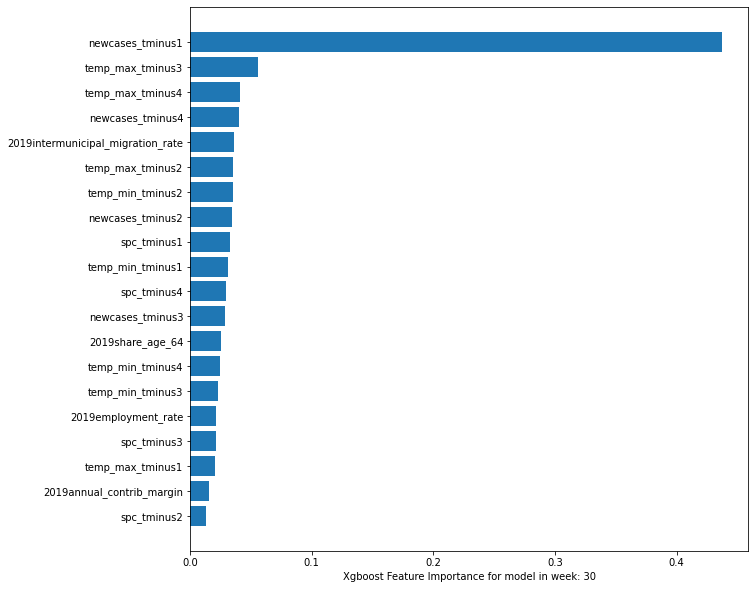

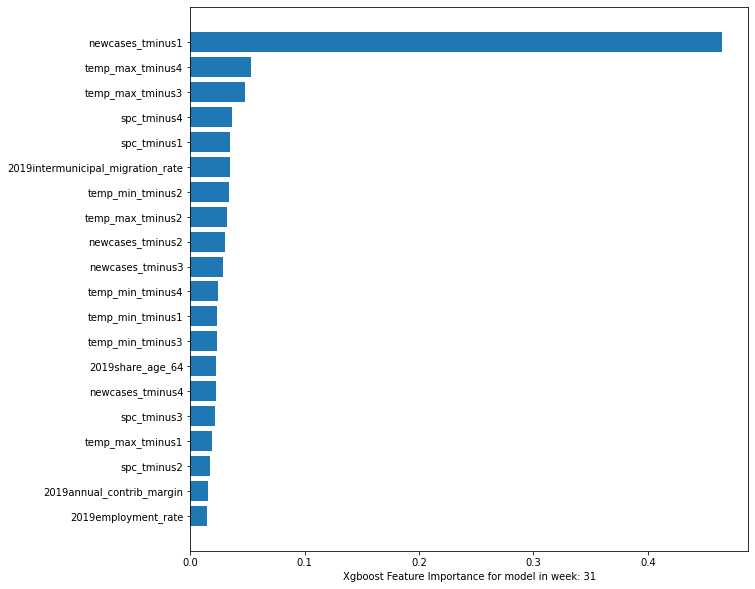

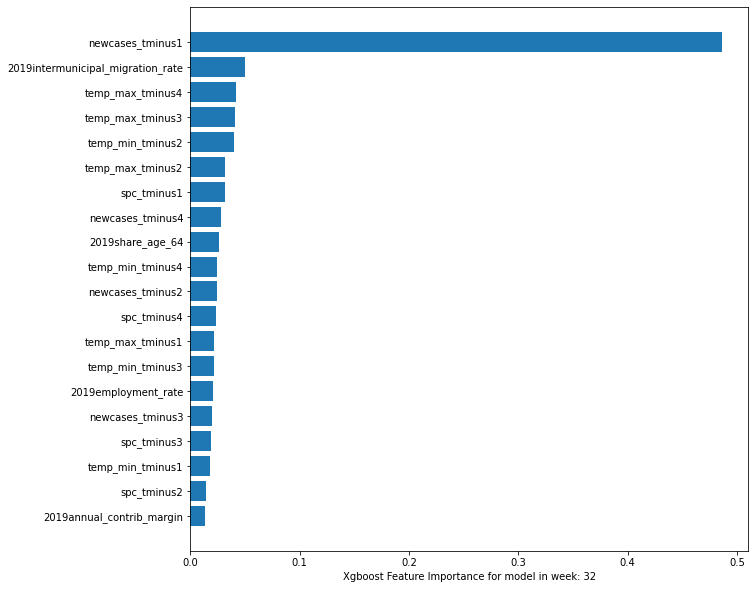

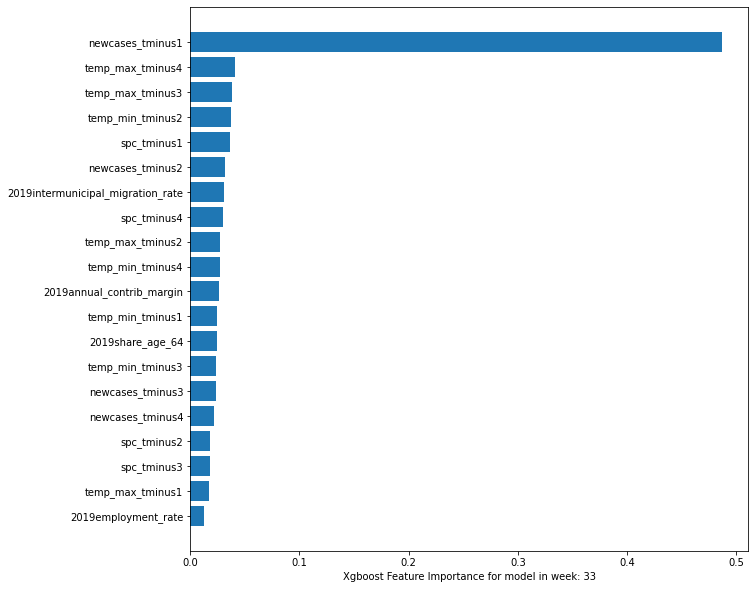

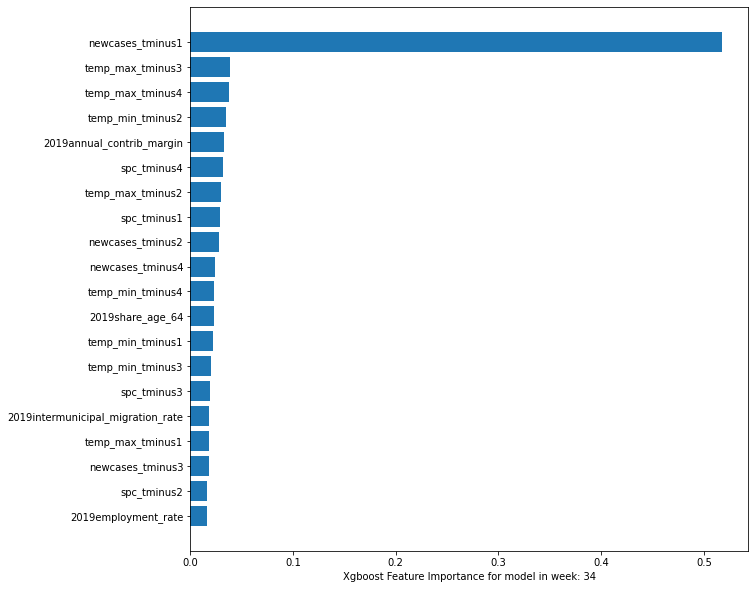

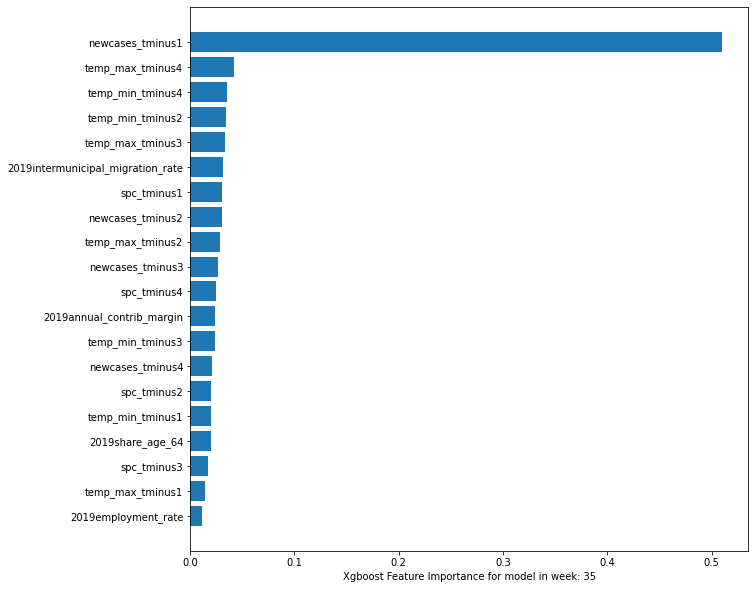

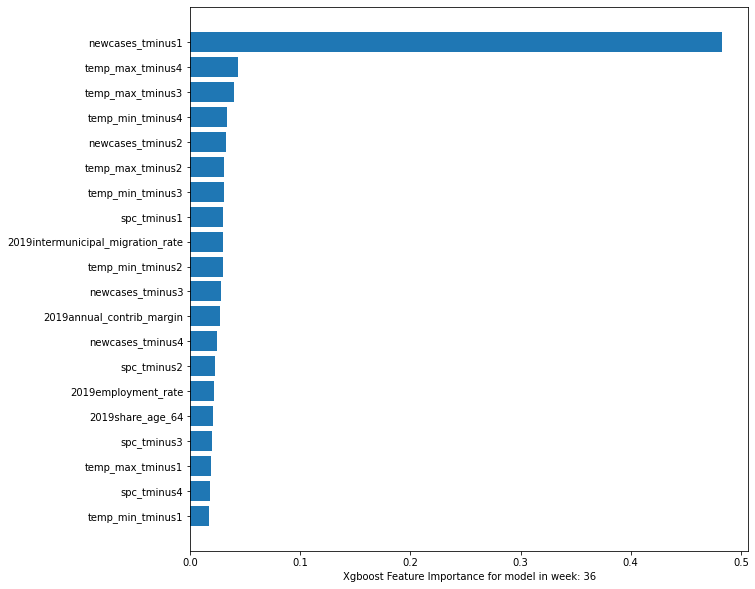

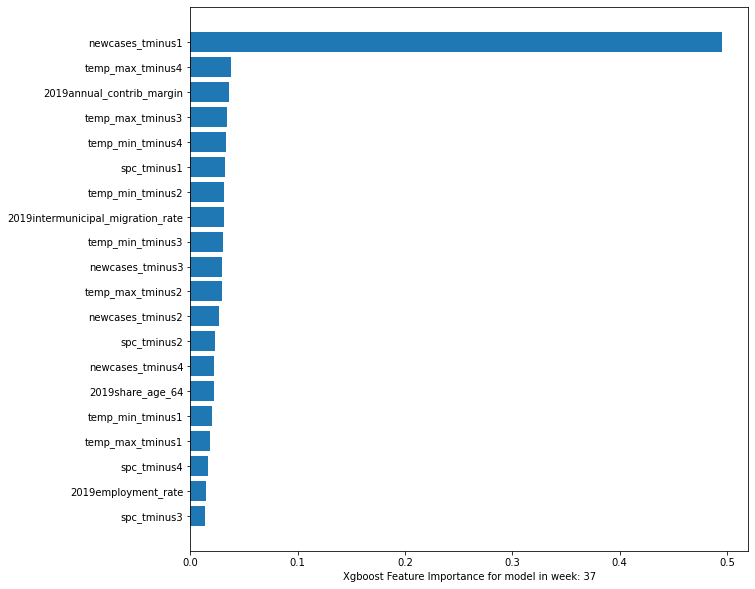

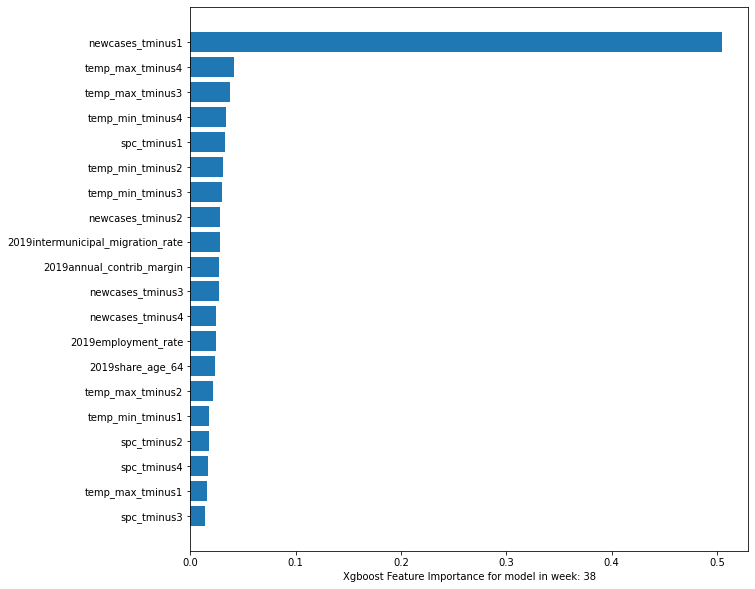

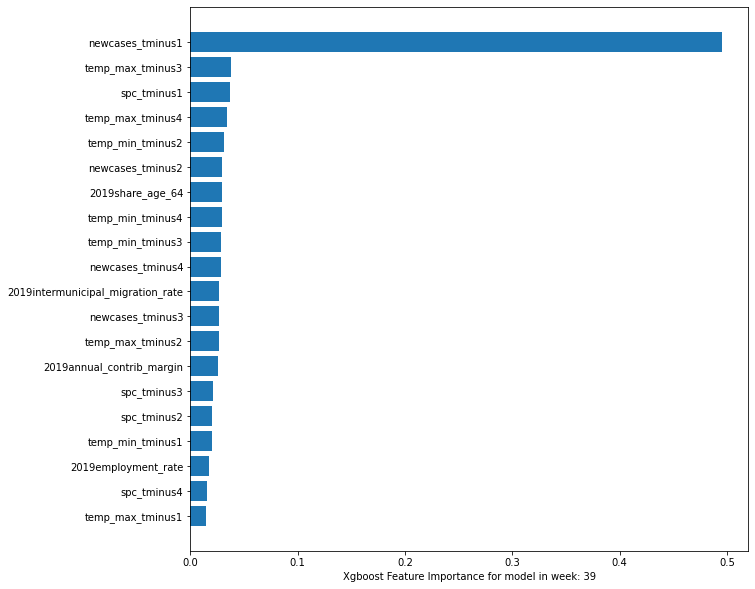

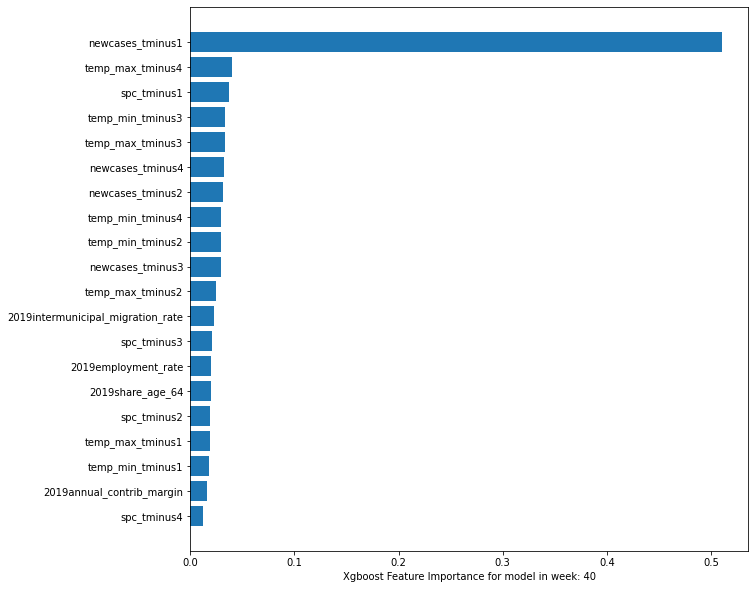

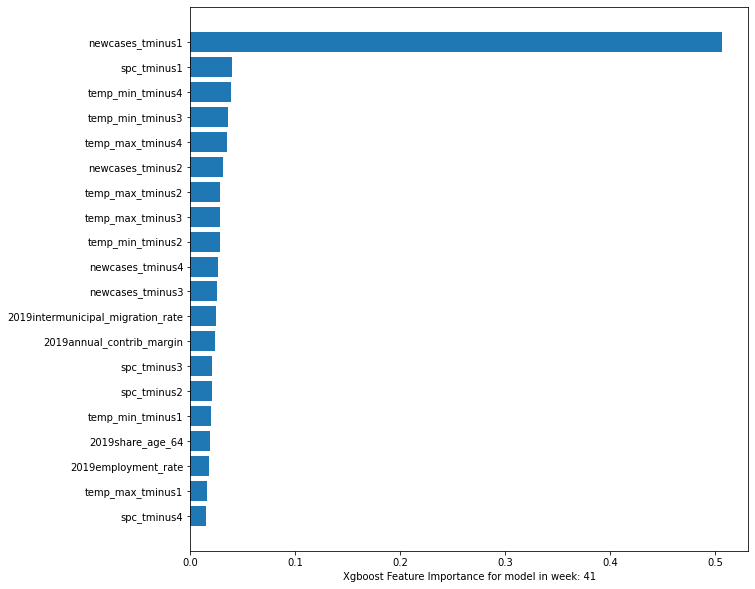

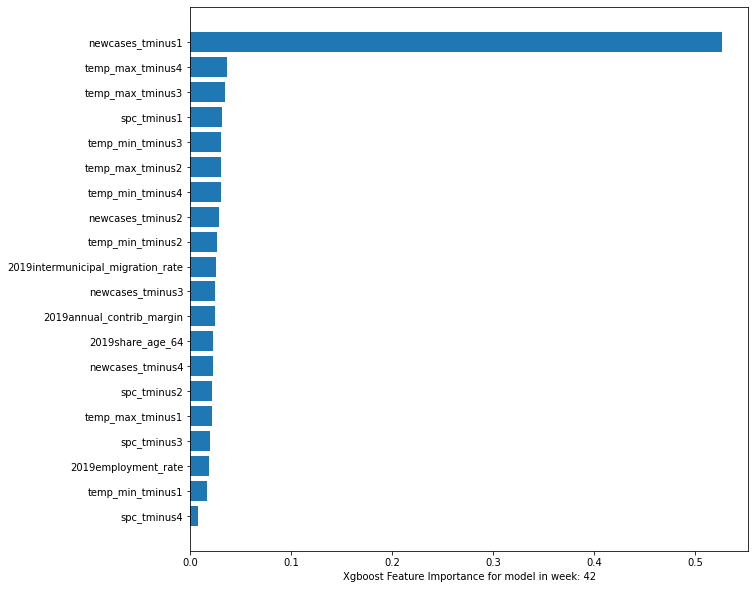

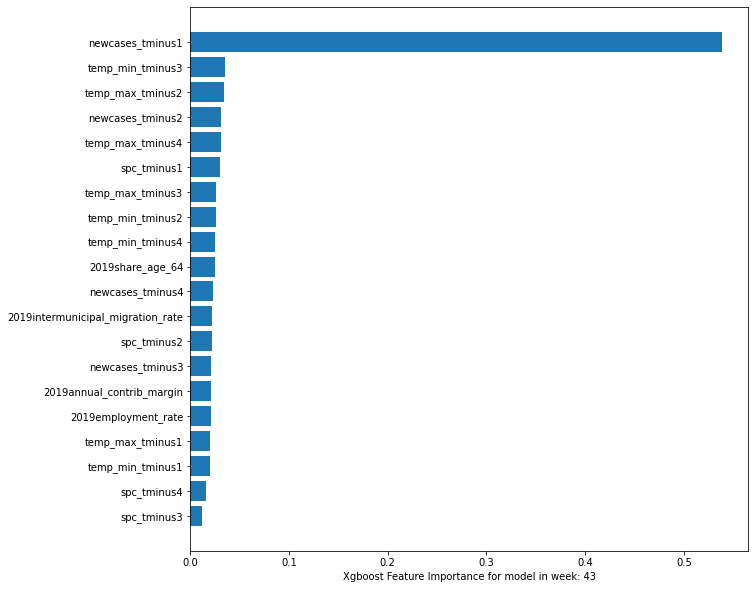

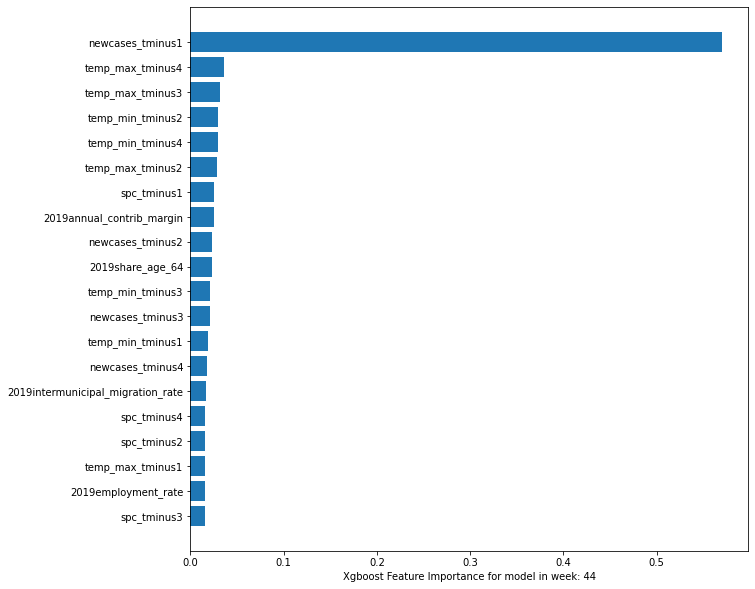

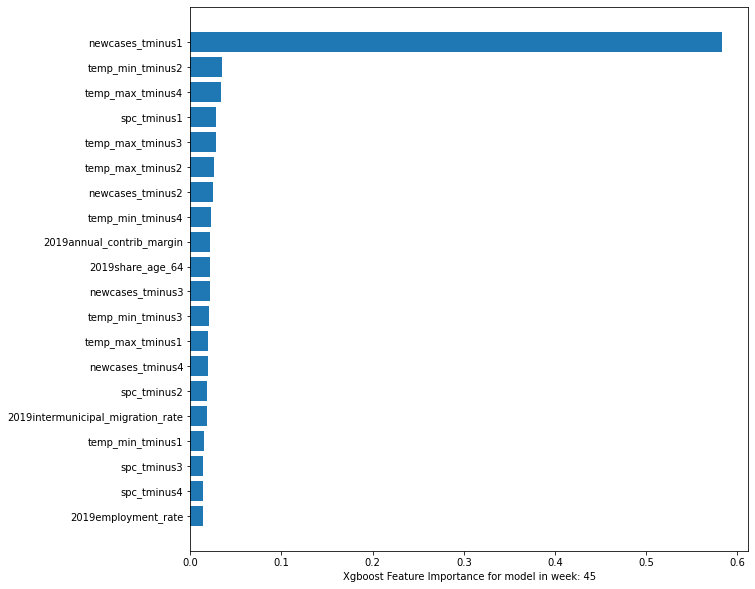

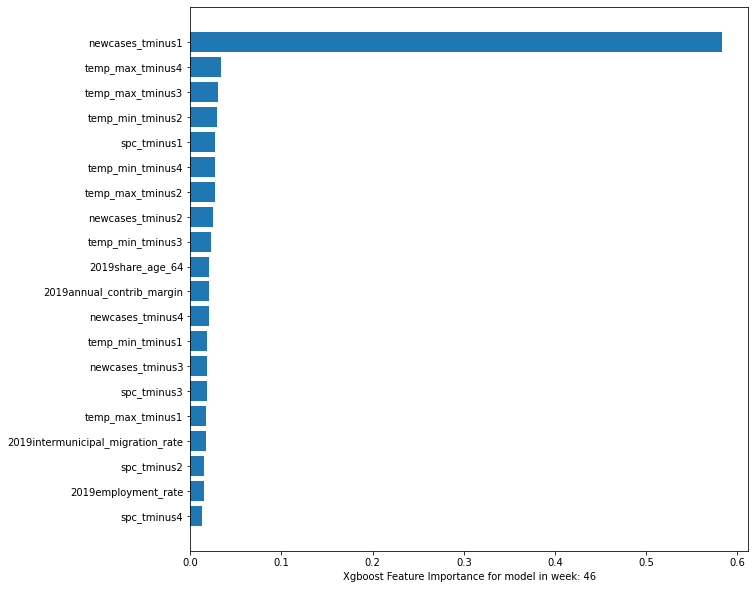

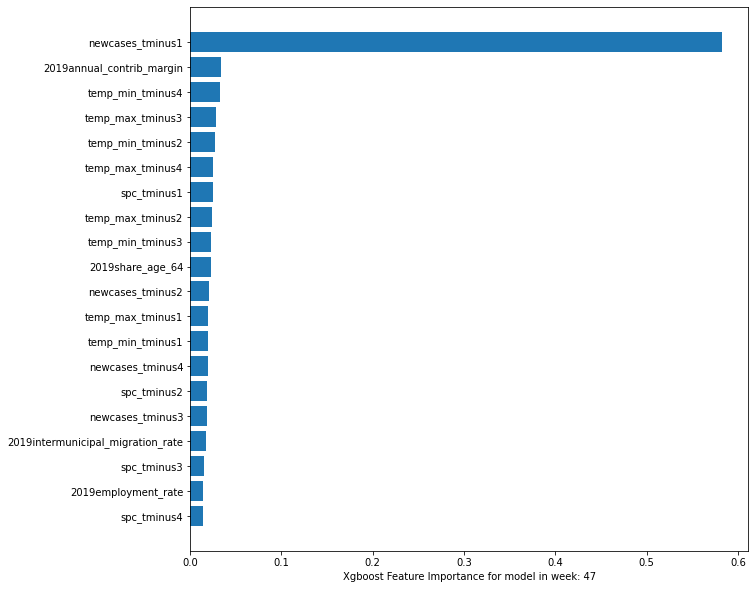

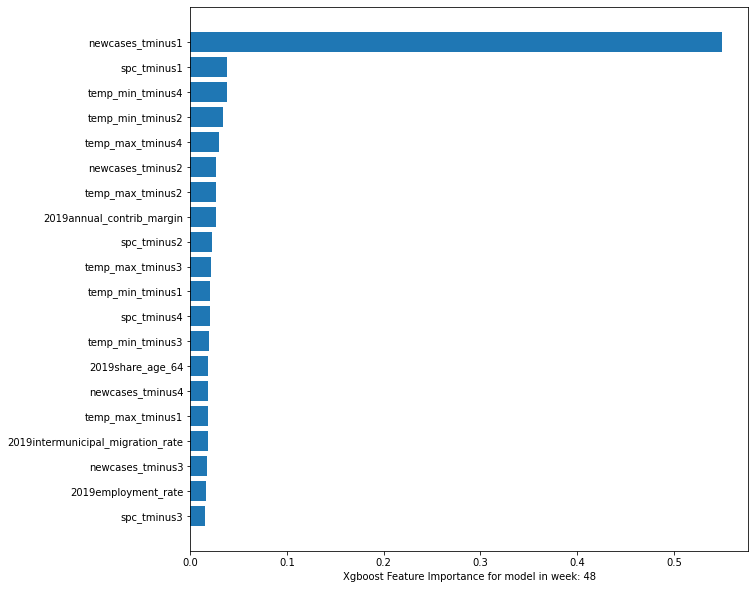

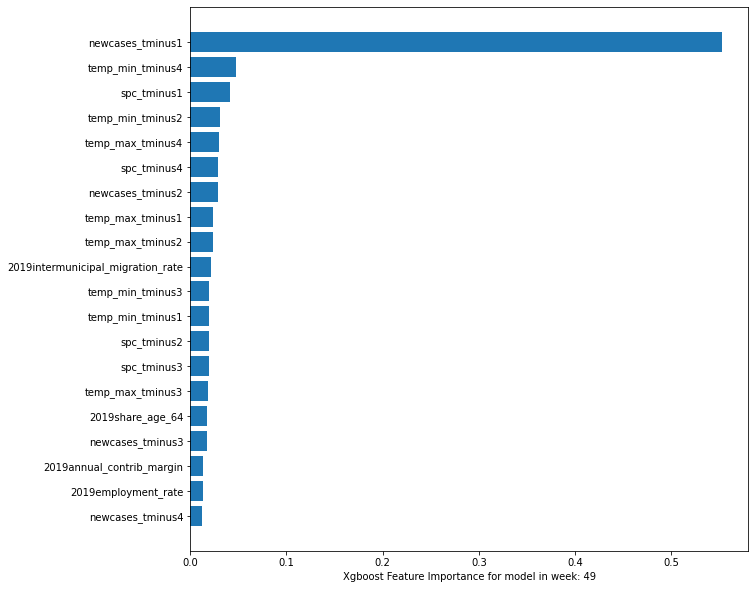

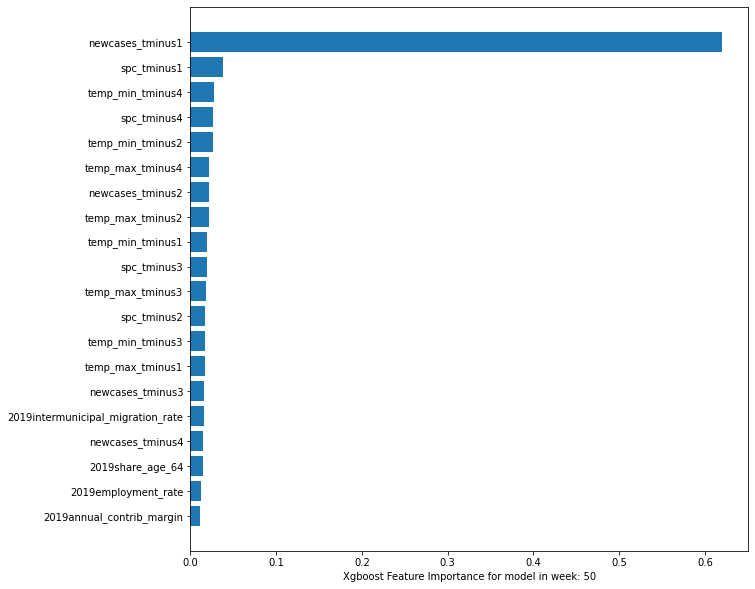

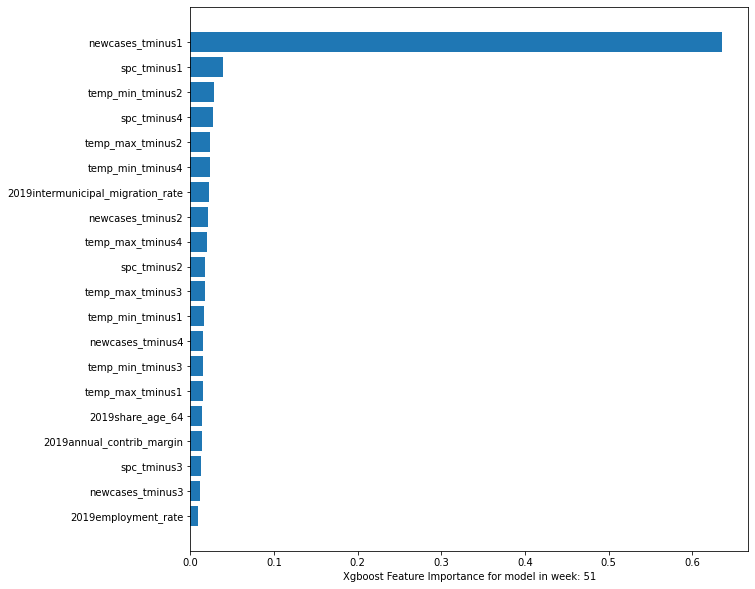

In [26]:
#get xgb predictions for all time steps:
for i in range(time_steps):
  learning_rate = tuned_xgb_params[i]['learning_rate']
  max_depth = tuned_xgb_params[i]['max_depth']
  predicted, real = get_stxgb_results(i, data,learning_rate,max_depth)
  result_week_dict = {'newcases{t}_real'.format(t=i+31): real, 'newcases{t}_predicted'.format(t=i+31): predicted}
  result_week_df = pd.DataFrame(result_week_dict)
  result_week_df.reset_index(drop=True,inplace=True)
  result_df = pd.concat([result_df, result_week_df],axis=1)
  #df1
  #result_week_df







In [27]:
result_df.head()

,province,newcases31_real,newcases31_predicted,newcases32_real,newcases32_predicted,newcases33_real,newcases33_predicted,newcases34_real,newcases34_predicted,newcases35_real,...,newcases48_real,newcases48_predicted,newcases49_real,newcases49_predicted,newcases50_real,newcases50_predicted,newcases51_real,newcases51_predicted,newcases52_real,newcases52_predicted
0,South Karelia,2.222914,2.790581,2.976522,2.534768,2.686673,2.123235,2.889567,2.340657,2.628703,...,4.048964,4.589148,3.846069,4.604711,5.034451,3.858621,4.541707,5.374643,12.222710,6.709479
1,Southern Ostrobothnia,1.516605,1.065730,1.688914,1.692774,1.861223,1.553081,2.205841,1.707163,1.229424,...,3.201403,3.783111,3.469439,3.092211,3.029094,3.608278,6.111508,3.381989,14.056862,7.025285
2,Southern Savonia,1.254991,1.573117,2.225268,1.566216,1.615379,2.394434,1.892602,1.605377,1.643102,...,2.447046,1.946303,3.528213,2.438749,2.862879,3.604046,4.082657,2.866382,9.238991,3.996920
3,Kainuu,2.113233,2.786235,2.267235,2.203616,4.885265,1.754198,5.193268,3.463784,2.831908,...,3.037244,1.074064,4.731263,3.391490,3.037244,4.994752,1.651228,3.212025,7.811299,1.546478
4,Tavastia Proper,2.050087,2.394212,1.855986,1.853881,2.740224,1.458590,3.149992,2.293834,2.222621,...,5.781138,4.913555,6.406574,6.139965,7.851548,6.429686,8.455417,8.430282,24.263857,9.281276


In [ ]:
df2 = result_df.sum()



In [ ]:
df2

province                South KareliaSouthern OstrobothniaSouthern Sav...
newcases31_real                                                 44.839139
newcases31_predicted                                            44.183605
newcases32_real                                                 44.780629
newcases32_predicted                                            45.468506
newcases33_real                                                 42.894047
newcases33_predicted                                            39.069611
newcases34_real                                                 40.881811
newcases34_predicted                                            38.044476
newcases35_real                                                  37.70642
newcases35_predicted                                            35.336132
newcases36_real                                                 33.377365
newcases36_predicted                                            32.755951
newcases37_real                       

In [ ]:
result_dict = df2.to_dict()

In [ ]:
result_dict.pop('province', None)

'South KareliaSouthern OstrobothniaSouthern SavoniaKainuuTavastia ProperCentral OstrobothniaCentral FinlandKymenlaaksoLaplandPirkanmaaOstrobothniaNorth KareliaNorthern OstrobothniaNorthern SavoniaPäijänne TavastiaSatakuntaUusimaaSouthwest Finland'

In [ ]:
print(result_dict)

{'newcases31_real': 44.839138544583825, 'newcases31_predicted': 44.1836051940918, 'newcases32_real': 44.78062948430971, 'newcases32_predicted': 45.468505859375, 'newcases33_real': 42.89404669613391, 'newcases33_predicted': 39.069610595703125, 'newcases34_real': 40.8818114534463, 'newcases34_predicted': 38.04447555541992, 'newcases35_real': 37.70642038920692, 'newcases35_predicted': 35.33613204956055, 'newcases36_real': 33.37736536432883, 'newcases36_predicted': 32.755950927734375, 'newcases37_real': 33.39829478352383, 'newcases37_predicted': 29.14199447631836, 'newcases38_real': 33.95429415644552, 'newcases38_predicted': 29.01841163635254, 'newcases39_real': 43.688126927111405, 'newcases39_predicted': 30.677154541015625, 'newcases40_real': 48.91436012908504, 'newcases40_predicted': 39.00281524658203, 'newcases41_real': 41.284197244358666, 'newcases41_predicted': 41.79458236694336, 'newcases42_real': 38.702605971805475, 'newcases42_predicted': 34.5250358581543, 'newcases43_real': 45.320

In [ ]:
real_cases = []
predicted_cases = []
for key in result_dict.keys():
  if 'real' in key:
    real_cases.append(result_dict[key])
  else:
    predicted_cases.append(result_dict[key])



In [ ]:
x_axis = np.arange(31, 53, 1)

In [ ]:
x_axis

array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52])

In [ ]:
real_cases

[44.839138544583825,
 44.78062948430971,
 42.89404669613391,
 40.8818114534463,
 37.70642038920692,
 33.37736536432883,
 33.39829478352383,
 33.95429415644552,
 43.688126927111405,
 48.91436012908504,
 41.284197244358666,
 38.702605971805475,
 45.32025596260074,
 55.21945777783152,
 60.01061552434076,
 73.44953826494242,
 78.941698561204,
 89.30984138574559,
 99.83405909310174,
 116.80383421713972,
 156.2849790260405,
 336.6915261771709]

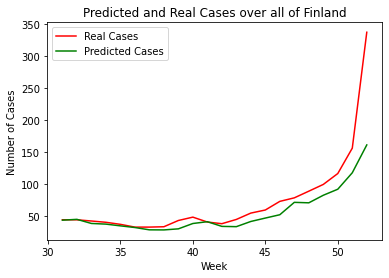

In [ ]:
fig, ax = plt.subplots()

ax.plot(x_axis, real_cases, color= 'red', label='Real Cases')
ax.plot(x_axis, predicted_cases, color= 'green', label='Predicted Cases')
ax.legend(loc = 'upper left')

plt.xlabel("Week")
plt.ylabel("Number of Cases")
plt.title("Predicted and Real Cases over all of Finland")
plt.show()

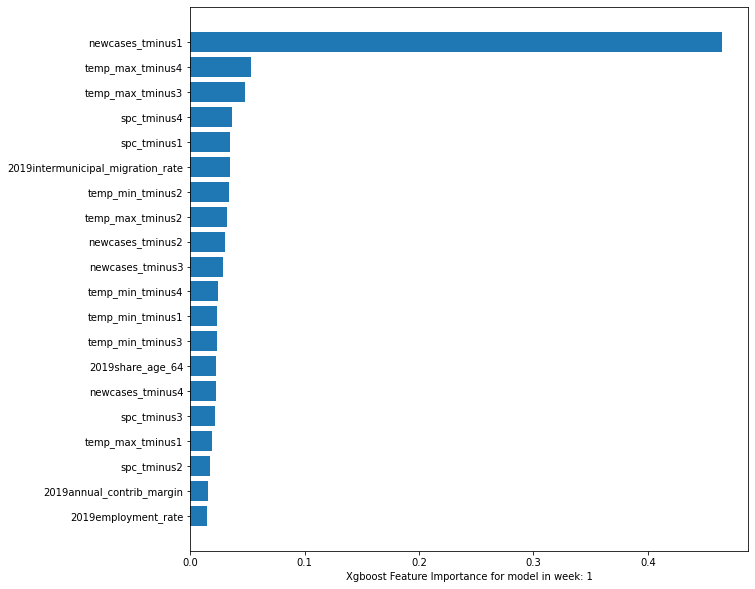

In [ ]:
predicted, real = get_stxgb_results(1, data, 0.05, 3)

In [ ]:
result_week_dict = {'newcases30_plus1_real': real}
result_week_df = pd.DataFrame(result_week_dict)
result_week_df.reset_index(drop=True,inplace=True)
result_week_df

,newcases30_plus1_real
0,2.976522
1,1.688914
2,2.225268
3,2.267235
4,1.855986
5,1.395959
6,2.540473
7,2.311080
8,3.033295
9,3.097853


In [ ]:
df1 = pd.concat([result_df, result_week_df],axis=1)
df1

,province,newcases31_real,newcases31_predicted,newcases32_real,newcases32_predicted,newcases33_real,newcases33_predicted,newcases34_real,newcases34_predicted,newcases35_real,...,newcases48_predicted,newcases49_real,newcases49_predicted,newcases50_real,newcases50_predicted,newcases51_real,newcases51_predicted,newcases52_real,newcases52_predicted,newcases30_plus1_real
0,South Karelia,2.222914,2.790581,2.976522,2.534768,2.686673,2.123235,2.889567,2.340657,2.628703,...,4.589148,3.846069,4.604711,5.034451,3.858621,4.541707,5.374643,12.222710,6.709479,2.976522
1,Southern Ostrobothnia,1.516605,1.065730,1.688914,1.692774,1.861223,1.553081,2.205841,1.707163,1.229424,...,3.783111,3.469439,3.092211,3.029094,3.608278,6.111508,3.381989,14.056862,7.025285,1.688914
2,Southern Savonia,1.254991,1.573117,2.225268,1.566216,1.615379,2.394434,1.892602,1.605377,1.643102,...,1.946303,3.528213,2.438749,2.862879,3.604046,4.082657,2.866382,9.238991,3.996920,2.225268
3,Kainuu,2.113233,2.786235,2.267235,2.203616,4.885265,1.754198,5.193268,3.463784,2.831908,...,1.074064,4.731263,3.391490,3.037244,4.994752,1.651228,3.212025,7.811299,1.546478,2.267235
4,Tavastia Proper,2.050087,2.394212,1.855986,1.853881,2.740224,1.458590,3.149992,2.293834,2.222621,...,4.913555,6.406574,6.139965,7.851548,6.429686,8.455417,8.430282,24.263857,9.281276,1.855986
5,Central Ostrobothnia,1.720616,0.973667,1.395959,1.928793,1.395959,1.248348,1.558288,1.500162,1.341850,...,2.321810,1.612397,1.635080,5.616498,2.053175,4.696637,6.943875,9.782927,4.177516,1.395959
6,Central Finland,2.338057,2.324623,2.540473,2.349410,1.649845,1.867596,0.678250,1.561270,0.813194,...,3.696134,5.482245,4.866508,7.276996,5.448441,8.262085,8.265662,16.061831,10.429659,2.540473
7,Kymenlaakso,2.243294,3.035854,2.311080,2.356200,2.265889,2.417625,1.926959,2.199674,1.926959,...,3.156661,3.440847,5.063535,3.034131,3.783521,7.982513,3.423361,20.658505,9.796121,2.311080
8,Lapland,2.929177,1.457547,3.033295,2.548314,2.137882,2.585527,0.805174,1.860389,1.596470,...,3.714025,7.052243,4.603364,6.677418,7.527939,7.947656,7.291831,16.464492,9.108885,3.033295
9,Pirkanmaa,4.181399,4.132275,3.097853,4.391502,1.943947,2.461960,2.077631,1.352648,2.739016,...,6.170166,10.098688,7.366308,10.366056,8.186860,14.249937,10.008496,23.108279,12.835610,3.097853
